In [31]:
#import necessary packages
from datetime import datetime
#import it in console with: pip install pandas-datareader
import pandas_datareader.data as wb
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# Input
# ticker: list of chosen stock
# start_date: start date of search in YYYY-M-D format
# end_date: start date of search in YYYY-M-D format
# Output
# Pandas dataframe with fiance data
def get_data_from_api(ticker, start_date, end_date):
    dataframe = pd.DataFrame()
    dataframe = wb.DataReader(ticker, 'yahoo', start_date, end_date)
    return dataframe

In [27]:
# Get stock data about Microsoft and Apple from 1990-01-01 to 2021-01-01
tickerList = ['MSFT', 'AAPL']
start = datetime(1990,1,1)
end = datetime(2021,5,5)

df = get_data_from_api(tickerList, start, end)

In [28]:
#print information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7897 entries, 1990-01-02 to 2021-05-05
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, MSFT)  7897 non-null   float64
 1   (Adj Close, AAPL)  7897 non-null   float64
 2   (Close, MSFT)      7897 non-null   float64
 3   (Close, AAPL)      7897 non-null   float64
 4   (High, MSFT)       7897 non-null   float64
 5   (High, AAPL)       7897 non-null   float64
 6   (Low, MSFT)        7897 non-null   float64
 7   (Low, AAPL)        7897 non-null   float64
 8   (Open, MSFT)       7897 non-null   float64
 9   (Open, AAPL)       7897 non-null   float64
 10  (Volume, MSFT)     7897 non-null   float64
 11  (Volume, AAPL)     7897 non-null   float64
dtypes: float64(12)
memory usage: 802.0 KB


In [29]:
#Print first 10 closing price from Microsoft
df['Close']['MSFT'].head(10)

Date
1990-01-02    0.616319
1990-01-03    0.619792
1990-01-04    0.638021
1990-01-05    0.622396
1990-01-08    0.631944
1990-01-09    0.630208
1990-01-10    0.612847
1990-01-11    0.600694
1990-01-12    0.598090
1990-01-15    0.598090
Name: MSFT, dtype: float64

In [30]:
#Print first 10 closing price from Apple
df['Close']['AAPL'].head(10)

Date
1990-01-02    0.332589
1990-01-03    0.334821
1990-01-04    0.335938
1990-01-05    0.337054
1990-01-08    0.339286
1990-01-09    0.335938
1990-01-10    0.321429
1990-01-11    0.308036
1990-01-12    0.308036
1990-01-15    0.305804
Name: AAPL, dtype: float64

<AxesSubplot:xlabel='Date'>

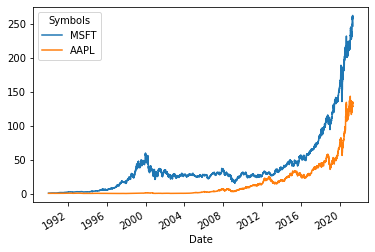

In [35]:
#Visualize the closing price
# plot line
df['Close'].plot()